## GSD test


In [16]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import utils
from snsynth import Synthesizer
from snsynth.gsd import GSDSynthesizer
import time
import yaml

# PUMS (Categorical + High-Cardinality-Ordinal)

In [17]:
git_root_dir = subprocess.check_output("git rev-parse --show-toplevel".split(" ")).decode("utf-8").strip()
meta_path = os.path.join(git_root_dir, os.path.join("datasets", "PUMS_pid.yaml"))
csv_path = os.path.join(git_root_dir, os.path.join("datasets", "PUMS_pid.csv"))
# csv_path = os.path.join(git_root_dir, os.path.join("datasets", "PUMS.csv"))
with open(meta_path, 'r') as file:
    pums_meta_data = yaml.safe_load(file)['']['PUMS']['PUMS']

pums_df = pd.read_csv(csv_path, index_col=None)
pums_df = pums_df.drop(["pid"], axis=1)

privacy budgets: First moments = 0.209729. Second moments = 1.572967
Cond.Marginal= ['age'] . Sigma=0.0098. Top.Level=5. Max.Size=None
Cond.Marginal= ['income'] . Sigma=0.0138. Top.Level=10. Max.Size=None
	Total size=2108
       age.tree_height = 4. Thresholds=22
    income.tree_height = 5. Thresholds=48
Cond.Marginal= ['age', 'income'] . Sigma=0.0098. Top.Level=5. Max.Size=None
Cond.Marginal= ['age', 'sex'] . Sigma=0.0087. Top.Level=4. Max.Size=None
Cond.Marginal= ['age', 'educ'] . Sigma=0.0087. Top.Level=4. Max.Size=None
Cond.Marginal= ['age', 'race'] . Sigma=0.0087. Top.Level=4. Max.Size=None
Cond.Marginal= ['age', 'married'] . Sigma=0.0087. Top.Level=4. Max.Size=None
Cond.Marginal= ['income', 'sex'] . Sigma=0.0098. Top.Level=5. Max.Size=None
Cond.Marginal= ['income', 'educ'] . Sigma=0.0098. Top.Level=5. Max.Size=None
Cond.Marginal= ['income', 'race'] . Sigma=0.0098. Top.Level=5. Max.Size=None
Cond.Marginal= ['income', 'married'] . Sigma=0.0098. Top.Level=5. Max.Size=None
Cond.Margi

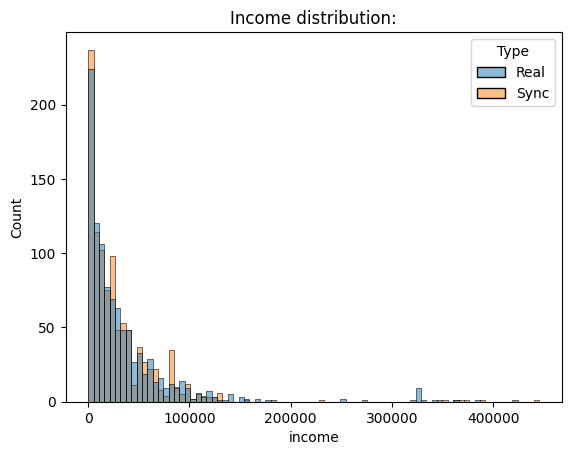

/Users/giuseppevietri/anaconda3/envs/smartnoise-sdk-gsd/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


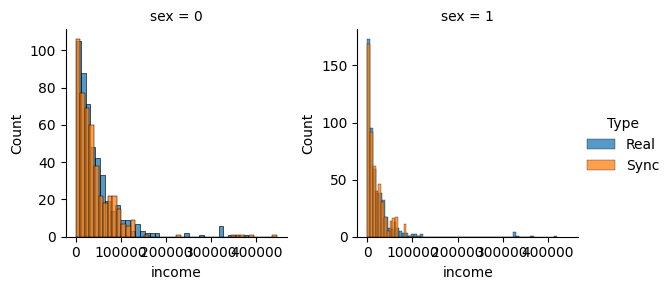

/Users/giuseppevietri/anaconda3/envs/smartnoise-sdk-gsd/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


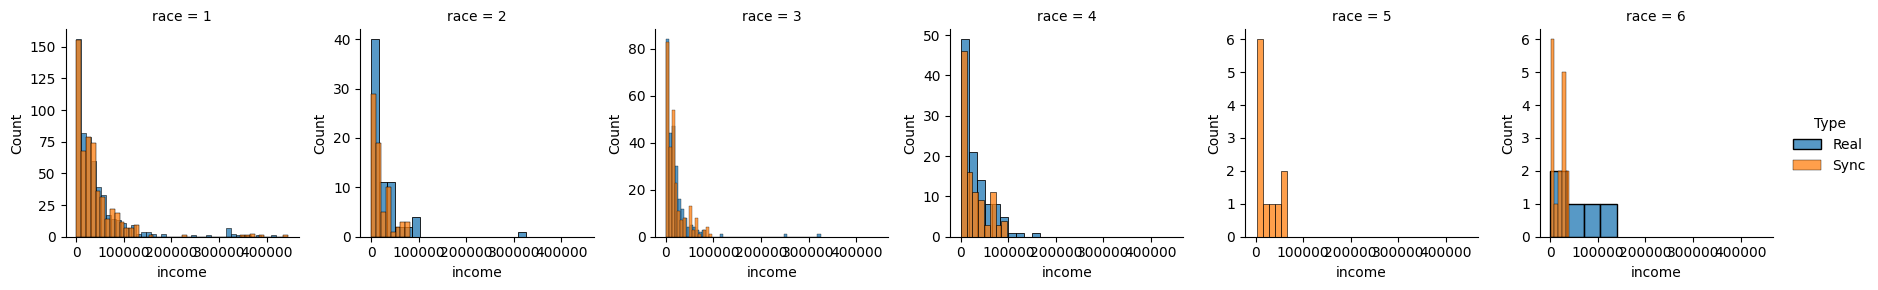

In [18]:
synth = GSDSynthesizer(10.0, 1e-5, verbose=True)
synth.fit(pums_df, meta_data=pums_meta_data, genetic_operators=['mutate', 'cross', 'continuous'])
pums_sync_df = synth.sample()
max_error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy())).max()
print(f'Statistical error:', max_error)



"""
Plot entire distribution:
"""
pums_sync_df['Type'] = 'Sync'
pums_all_temp = pums_df.copy()
pums_all_temp['Type'] = 'Real'
pums_real_sync = pd.concat((pums_all_temp, pums_sync_df))

plt.title('Income distribution:')
sns.histplot(data=pums_real_sync, x='income', hue='Type')
plt.show()


"""
Plot subgroups distributions:
"""
g = sns.FacetGrid(data=pums_real_sync, hue='Type',  col='sex', sharey=False)
g.map(sns.histplot, 'income')
g.add_legend()
plt.show()

g = sns.FacetGrid(data=pums_real_sync, hue='Type',  col='race', sharey=False)
g.map(sns.histplot, 'income')
g.add_legend()
# g.set(sharey=False)
plt.show()

# High cardinality

In [7]:
import time
rng = np.random.default_rng(0)

d = 1
ordinal_columns = 'categorical_1'
cat_cardinality = 10000
N = 2 * cat_cardinality

data_np = rng.integers(0, cat_cardinality, (N, d ))
data_np[:cat_cardinality, 0] = 0
data_np = data_np.astype(str)
data_df = pd.DataFrame(data_np, columns=[ordinal_columns])


t0 = time.time()
synth = GSDSynthesizer(3000.0, 1e-5, verbose=True)
# Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
synth.fit(data_np, N_prime=1000, genetic_operators=['mutate', 'cross'])
print(f'elapsed time = {time.time() - t0}')

error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy()))
print(f'epsilon={epsilon}', f'Statistical error: max={error.max():.4f}, Avg={error.mean():.4f}')

Cond.Marginal= [0] . Sigma=0.0000. Top.Level=1. Max.Size=None
	Total size=6328
Statistics size = 6328
Gen=      1000: fitness=0.019003768. Strategy wins:  [0.61 0.39] time=5.21 (s)
Gen=      2000: fitness=0.000378352214. Strategy wins:  [1. 0.] time=6.86 (s)
Gen=      3000: fitness=0.000376445237. Strategy wins:  [1. 0.] time=8.54 (s)
Gen=      4000: fitness=0.000376297967. Strategy wins:  [1. 0.] time=10.06(s)
Gen=      5000: fitness=0.000376277436. Strategy wins:  [1. 0.] time=11.58(s)
Gen=      6000: fitness=0.000376262702. Strategy wins:  [1. 0.] time=13.13(s)
		 ### Stop early at 6000 ###
elapsed time = 20.118804216384888
epsilon=10 Statistical error: max=0.0009, Avg=0.0001


In [8]:
# Run this cell to observe slow converge behavior without the cross genetic operator.
t0 = time.time()
synth = GSDSynthesizer(3000.0, 1e-5, verbose=True)
# Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
synth.fit(data_df, N_prime=1000, genetic_operators=['mutate'])
print(f'elapsed time = {time.time() - t0}')

Cond.Marginal= ['categorical_1'] . Sigma=0.0000. Top.Level=1. Max.Size=None
	Total size=6328
Statistics size = 6328
Gen=      1000: fitness=0.235053579. Strategy wins:  [1.] time=3.65 (s)
Gen=      2000: fitness=0.225453797. Strategy wins:  [1.] time=5.32 (s)
Gen=      3000: fitness=0.213285876. Strategy wins:  [1.] time=6.90 (s)
Gen=      4000: fitness=0.209609693. Strategy wins:  [1.] time=8.45 (s)
Gen=      5000: fitness=0.203254296. Strategy wins:  [1.] time=10.07(s)
Gen=      6000: fitness=0.194345383. Strategy wins:  [1.] time=11.61(s)
Gen=      7000: fitness=0.186498198. Strategy wins:  [1.] time=13.20(s)
Gen=      8000: fitness=0.179659091. Strategy wins:  [1.] time=14.69(s)
Gen=      9000: fitness=0.174613602. Strategy wins:  [1.] time=16.33(s)
Gen=     10000: fitness=0.167998519. Strategy wins:  [1.] time=17.97(s)
Gen=     11000: fitness=0.159909699. Strategy wins:  [1.] time=19.54(s)
Gen=     12000: fitness=0.154366581. Strategy wins:  [1.] time=20.98(s)
Gen=     13000: fitn

# Highly correlated categorical data.

In [11]:
rng = np.random.default_rng(1)

d = 1
columns = ['categorical_1', 'categorical_2']
cat_cardinality = 11
N = 200
values = rng.integers(1, cat_cardinality, (N, d ))
values[:190] = 0
data_np = np.column_stack((values, values)).astype(str)
correlated_cat_df = pd.DataFrame(data_np, columns=columns)

t0 = time.time()
synth = GSDSynthesizer(10000000.0, 1e-5, verbose=True)
# Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
synth.fit(correlated_cat_df, N_prime=200, genetic_operators=['mutate', 'cross', 'swap'])
print(f'elapsed time = {time.time() - t0}')

error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy()))
print(f'epsilon={epsilon}', f'Statistical error: max={error.max():.4f}, Avg={error.mean():.4f}')

privacy budgets: Second moments = 9899855.760007
Cond.Marginal= ['categorical_1', 'categorical_2'] . Sigma=0.0000. Top.Level=1. Max.Size=None
	Total size=64
Statistics size = 64
Gen=       200: fitness=0.162998484. Strategy wins:  [0.303 0.065 0.303 0.33 ] time=7.97 (s)
Gen=       400: fitness=9.98943138e-05. Strategy wins:  [0.104 0.    0.16  0.736] time=8.31 (s)
Gen=       600: fitness=9.98943138e-05. Strategy wins:  [0.104 0.    0.16  0.736] time=8.59 (s)
Gen=       800: fitness=9.9890692e-05. Strategy wins:  [0.093 0.    0.144 0.763] time=8.86 (s)
Gen=      1000: fitness=9.9890692e-05. Strategy wins:  [0.093 0.    0.144 0.763] time=9.12 (s)
Gen=      1200: fitness=9.9890692e-05. Strategy wins:  [0.093 0.    0.144 0.763] time=9.39 (s)
Gen=      1400: fitness=9.9890692e-05. Strategy wins:  [0.093 0.    0.144 0.763] time=9.66 (s)
Gen=      1600: fitness=9.9890692e-05. Strategy wins:  [0.093 0.    0.144 0.763] time=9.92 (s)
		 ### Stop early at 1600 ###
elapsed time = 11.23509407043457

In [12]:
## Run this cell to check slow convergence without the cross operator
t0 = time.time()
synth = GSDSynthesizer(10000000.0, 1e-5, verbose=True)
# Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
synth.fit(correlated_cat_df, N_prime=200, genetic_operators=['mutate', 'cross'])
print(f'elapsed time = {time.time() - t0}')

error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy()))
print(f'epsilon={epsilon}', f'Statistical error: max={error.max():.4f}, Avg={error.mean():.4f}')

privacy budgets: Second moments = 9899855.760007
Cond.Marginal= ['categorical_1', 'categorical_2'] . Sigma=0.0000. Top.Level=1. Max.Size=None
	Total size=64
Statistics size = 64
Gen=       200: fitness=0.13194967. Strategy wins:  [0.331 0.228 0.441] time=6.48 (s)
Gen=       400: fitness=0.000149812423. Strategy wins:  [0.052 0.033 0.915] time=6.76 (s)
Gen=       600: fitness=4.99378416e-05. Strategy wins:  [0.288 0.025 0.687] time=6.98 (s)
Gen=       800: fitness=4.99378416e-05. Strategy wins:  [0.288 0.025 0.687] time=7.20 (s)
Gen=      1000: fitness=4.99378416e-05. Strategy wins:  [0.288 0.025 0.687] time=7.42 (s)
Gen=      1200: fitness=4.99378416e-05. Strategy wins:  [0.288 0.025 0.687] time=7.64 (s)
		 ### Stop early at 1200 ###
elapsed time = 8.95582890510559
epsilon=10 Statistical error: max=0.0050, Avg=0.0002


In [10]:
"""
3-d correlated categorical data.
"""

rng = np.random.default_rng(0)

d = 1
columns = ['categorical_1', 'categorical_2', 'categorical_3']
cat_cardinality = 11
N = 200
values = rng.integers(1, cat_cardinality, (N, d ))
values[:190] = 0
data_np = np.column_stack((values, values, values)).astype(str)
correlated_cat_df = pd.DataFrame(data_np, columns=columns)

t0 = time.time()
synth = GSDSynthesizer(10000000.0, 1e-5, verbose=True)
# Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
synth.fit(correlated_cat_df, N_prime=200, genetic_operators=['mutate', 'cross'])
print(f'elapsed time = {time.time() - t0}')

error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy()))
print(f'epsilon={epsilon}', f'Statistical error: max={error.max():.4f}, Avg={error.mean():.4f}')

privacy budgets: Second moments = 9899855.760007
Cond.Marginal= ['categorical_1', 'categorical_2'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['categorical_1', 'categorical_3'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['categorical_2', 'categorical_3'] . Sigma=0.0000. Top.Level=1. Max.Size=None
	Total size=108
Statistics size = 108
Gen=       200: fitness=0.618189086. Strategy wins:  [0.401 0.278 0.321] time=7.76 (s)
Gen=       400: fitness=0.0172480823. Strategy wins:  [0.176 0.167 0.657] time=8.10 (s)
Gen=       600: fitness=0.000349889085. Strategy wins:  [0.511 0.091 0.397] time=8.35 (s)
Gen=       800: fitness=9.79843835e-10. Strategy wins:  [0.68 0.06 0.26] time=8.60 (s)
Gen=      1000: fitness=9.79843835e-10. Strategy wins:  [0.68 0.06 0.26] time=8.84 (s)
Gen=      1200: fitness=9.79843835e-10. Strategy wins:  [0.68 0.06 0.26] time=9.10 (s)
		 ### Stop early at 1200 ###
elapsed time = 11.46962594985962
Statistical error: 0.0


# Real-valued low variance

epsilon=100
Cond.Marginal= ['z'] . Sigma=0.0007. Top.Level=12. Max.Size=None
	Total size=8190
Statistics size = 13
Gen=      1000: fitness=0.270941663. Strategy wins:  [0.072 0.928] time=6.47 (s)
Gen=      2000: fitness=0.000776905055. Strategy wins:  [0. 1.] time=8.69 (s)
Gen=      3000: fitness=0.000684690974. Strategy wins:  [0. 1.] time=10.80(s)
Gen=      4000: fitness=0.000602060664. Strategy wins:  [0. 1.] time=12.83(s)
Gen=      5000: fitness=0.000450539349. Strategy wins:  [0. 1.] time=15.06(s)
Gen=      6000: fitness=0.000356940471. Strategy wins:  [0. 1.] time=16.74(s)
Gen=      7000: fitness=0.000285178119. Strategy wins:  [0. 1.] time=18.41(s)
Gen=      8000: fitness=0.000244602699. Strategy wins:  [0. 1.] time=20.10(s)
Gen=      9000: fitness=0.000185183489. Strategy wins:  [0. 1.] time=21.84(s)
Gen=     10000: fitness=0.000142951512. Strategy wins:  [0.002 0.998] time=23.51(s)
Gen=     11000: fitness=0.000103554674. Strategy wins:  [0.105 0.895] time=25.29(s)
Gen=     120

/Users/giuseppevietri/anaconda3/envs/smartnoise-sdk-gsd/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


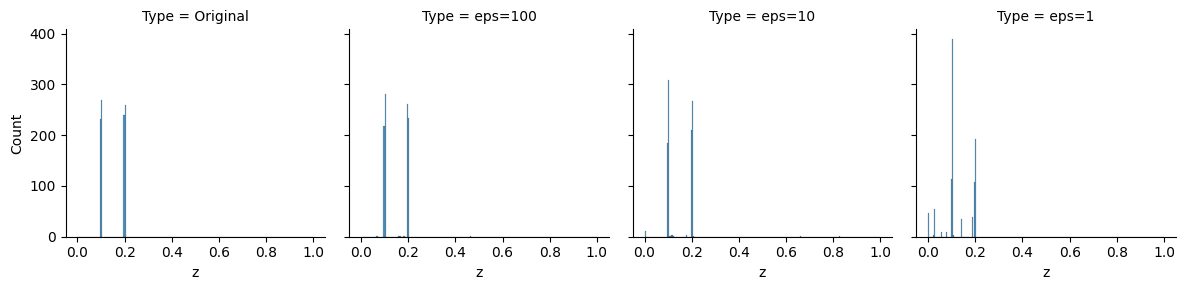

In [3]:
# Real-valued data
"""
In some situations the input data in concentrated in a small regions. In these case we must increase 
the granularity of the queries. 
"""


collect = []
rng = np.random.default_rng(0)

N = 1000
z = np.concatenate([0.0001 * np.random.randn(N//2) + 0.1, 0.0003 * np.random.randn(N//2) + 0.2]).reshape((N,1))
cont_cols = ['z']
data_cont_df = pd.DataFrame(z, columns=cont_cols)
meta_data = {'z': {'type': 'float', 'lower': 0, 'upper': 1} }

plot_data = data_cont_df.copy()
plot_data.loc[:, 'Type'] = 'Original'
collect.append(plot_data)

# Run GSD

for epsilon in [100, 10, 1]:
    print(f'epsilon={epsilon}')
    synth = GSDSynthesizer(float(epsilon), 1e-5, tree_height=12, verbose=True)
    # Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
    synth.fit(data_cont_df, meta_data=meta_data, 
              genetic_operators=['mutate', 'continuous'])
    error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy()))
    print(f'epsilon={epsilon}', f'Statistical error: max={error.max():.4f}, Avg={error.mean():.4f}')

    sync_df = synth.sample()
    sync_df.loc[:, 'Type'] = f'eps={epsilon}'
    collect.append(sync_df)

all_data = pd.concat(collect)
g= sns.FacetGrid(data=all_data, col='Type')
g.map(sns.histplot, "z", binrange=(0,1), bins=200)
plt.show()

# Real-valued data: 2-dimensional

In [ ]:
import matplotlib.pyplot as plt
rng = np.random.default_rng(0)

collect = []

mean = [0.5, 0.5]
cov = [[.01, 0.0099], 
       [0.0099, .01]]  # diagonal covariance

N = 200

x, y = np.random.multivariate_normal(mean, cov, N).T
values_cont = np.column_stack((x, y))
values_cont[100:300, 0] = 0.03
values_cont[100:300, 1] = 0.93

cont_cols = ['c1', 'c2']
data_cont_df = pd.DataFrame(values_cont, columns=cont_cols)
meta_data = {'c1': {'type': 'float', 'lower': 0, 'upper': 1}, 'c2': {'type': 'float', 'lower': 0, 'upper': 1}}

plot_data = data_cont_df.copy()
plot_data.loc[:, 'Type'] = 'Original'
collect.append(plot_data)


for epsilon in [1000, 100]:
    print(f'epsilon={epsilon}')
    synth = GSDSynthesizer(float(epsilon), 1e-5, tree_height=12, verbose=True)
    synth.fit(data_cont_df, meta_data=meta_data, 
              genetic_operators=['mutate', 'continuous'])
    error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy()))
    print(f'epsilon={epsilon}', f'Statistical error: max={error.max():.4f}, Avg={error.mean():.4f}')

    sync_df = synth.sample()
    sync_df.loc[:, 'Type'] = f'eps={epsilon}'
    collect.append(sync_df)

    synth = GSDSynthesizer(float(epsilon), 1e-5, tree_height=12, verbose=True)
    # Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
    synth.fit(data_cont_df, meta_data=meta_data, 
              genetic_operators=['mutate', 'continuous', 'swap'])
    error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy()))
    print(f'epsilon={epsilon}', f'Statistical error: max={error.max():.4f}, Avg={error.mean():.4f}')
    sync_df = synth.sample()
    sync_df.loc[:, 'Type'] = f'eps={epsilon}/swap'
    collect.append(sync_df)



/Users/giuseppevietri/anaconda3/envs/smartnoise-sdk-gsd/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


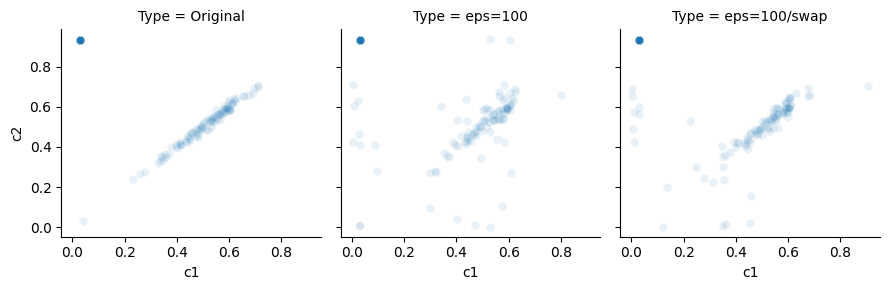

In [6]:
all_data = pd.concat(collect)
g= sns.FacetGrid(data=all_data, col='Type', sharey=True,sharex=True)
g.map(sns.scatterplot, "c1", "c2", alpha=0.1)
plt.show()

# End